(10, 1, 16, 16)
1


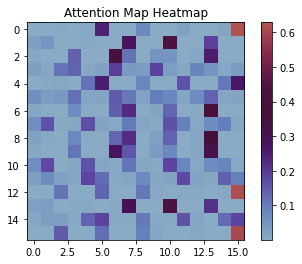

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib as mpl
import random

attention_maps = np.load('/data/workspace/yancheng/MM/causal_physical_system/attention_map/Attention_map.npy')
print(attention_maps.shape)

mycolor=['#89ABC5','#6785BE','#5D46A3','#491463','#45113C','#4E1344','#87274F','#B15352']
cmap_color = mpl.colors.LinearSegmentedColormap.from_list('my_list', mycolor)
cmap = cmap_color

batch_index = random.randint(0, 10)
print(batch_index)
attention_map = attention_maps[batch_index][0]
attention_map = attention_map
plt.imshow(attention_map, cmap=cmap)
plt.colorbar()
plt.title('Attention Map Heatmap')
plt.show()

(16, 16)


(array([ 7, 13,  0, 15,  8]),
 array([1.3936149, 1.6591594, 1.7421952, 1.781754 , 2.0133796],
       dtype=float32),
 array([ 1, 12,  9,  4,  2]),
 array([0.36159927, 0.41382307, 0.4228723 , 0.45550552, 0.57763755],
       dtype=float32))

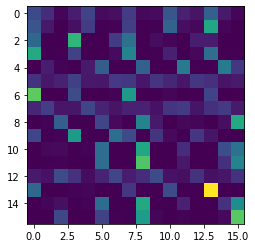

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

time_index = 0
attentionmap = attention_maps[time_index][0]
attentionmap = attentionmap
print(attentionmap.shape)
plt.imshow(attentionmap)
column_sums = np.sum(attentionmap, axis=0)
largest_indices = np.argsort(column_sums)[-5:]
smallest_indices = np.argsort(column_sums)[:5]
largest_sums = column_sums[largest_indices]
smallest_sums = column_sums[smallest_indices]
largest_indices, largest_sums, smallest_indices, smallest_sums

In [3]:
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy.io as sio


class NS2DDataset1e5(Dataset):
    def __init__(self, data_path, transform=None):
        self.metadata = sio.loadmat(data_path)
        self.data = self.metadata["u"]
        self.data = torch.from_numpy(self.data)
        self.data = self.data.permute(0, 3, 1, 2)
        self.data.unsqueeze_(2)  
        self.transform = transform
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_frames = self.data[idx][:10]
        output_frames = self.data[idx][10:]

        input_frames = (input_frames - self.mean) / self.std
        output_frames = (output_frames - self.mean) / self.std

        return input_frames, output_frames

def load_data(batch_size, val_batch_size, data_root, num_workers):
    train_dataset = NS2DDataset1e5(data_path=data_root + 'train_data.mat', transform=None)
    test_dataset = NS2DDataset1e5(data_path=data_root + 'test_data.mat', transform=None)
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                  num_workers=num_workers)
    dataloader_validation = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=True,
                                       num_workers=num_workers)
    dataloader_test = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=True,
                                 num_workers=num_workers)

    mean, std = train_dataset.mean, train_dataset.std
    return dataloader_train, dataloader_validation, dataloader_test, mean, std

In [4]:
if __name__ == '__main__':
    dataloader_train, dataloader_validation, dataloader_test, mean, std = load_data(batch_size=10, 
                                                                                    val_batch_size=10, 
                                                                                    data_root='/data/workspace/yancheng/MM/neural_manifold_operator/data/',
                                                                                    num_workers=8)
    for input_frames, output_frames in iter(dataloader_train):
        print(input_frames.shape, output_frames.shape)
        break

torch.Size([10, 10, 1, 64, 64]) torch.Size([10, 10, 1, 64, 64])


In [5]:
input_frames = input_frames.reshape(10,10,64,64)
print(input_frames.shape)
attention_maps = np.load('/data/workspace/yancheng/MM/causal_physical_system/attention_map/Attention_map.npy')
attention_maps = attention_maps.reshape(10,16,16)
print(attention_maps.shape)

torch.Size([10, 10, 64, 64])
(10, 16, 16)


In [6]:
import numpy as np

min_attention_indices_per_image = np.argmin(attention_maps.reshape(attention_maps.shape[0], -1), axis=1)
min_attention_positions = np.unravel_index(min_attention_indices_per_image, attention_maps.shape[1:])

min_attention_positions


(array([ 6,  0,  9, 10, 13,  6,  8,  6,  9,  9]),
 array([ 8, 13, 15,  0, 15,  8,  2,  8, 15, 15]))

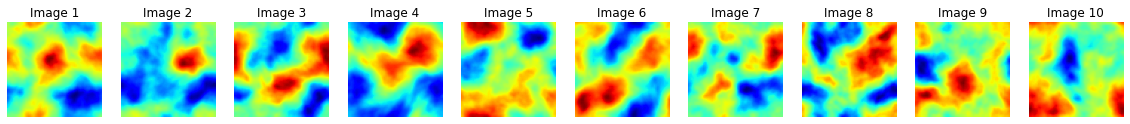

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches



min_attention_indices_per_image = np.argmin(attention_maps.reshape(attention_maps.shape[0], -1), axis=1)
min_attention_positions = np.unravel_index(min_attention_indices_per_image, attention_maps.shape[1:])

def visualize_min_attention_patches(input_frames, min_attention_positions, patch_size=16):
    fig, axs = plt.subplots(1, input_frames.shape[0], figsize=(20, 20))
    for i, ax in enumerate(axs):
        img = input_frames[i, 0] 
        ax.imshow(img, cmap='jet')
        
        row, col = min_attention_positions
        rect = patches.Rectangle((col[i]*patch_size, row[i]*patch_size),
                                 patch_size, patch_size, linewidth=10, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')
    plt.show()

visualize_min_attention_patches(input_frames, min_attention_positions)


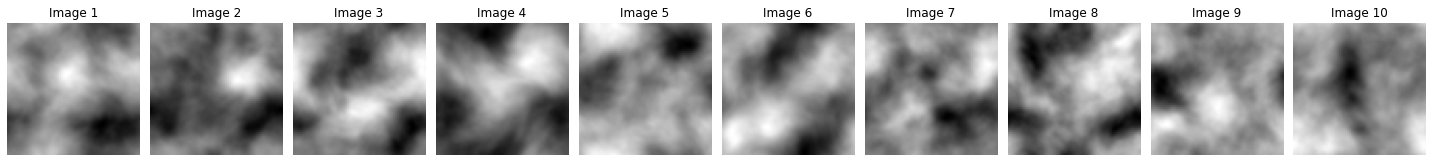

In [8]:
min_attention_indices_per_image = np.argmin(attention_maps.reshape(attention_maps.shape[0], -1), axis=1)
min_attention_positions = np.unravel_index(min_attention_indices_per_image, attention_maps.shape[1:])
def visualize_min_attention_patches_on_original_images(input_frames, min_attention_positions, patch_size=16):
    fig, axs = plt.subplots(1, len(input_frames), figsize=(20, 20))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(input_frames[i, 0], cmap='gray')
        row, col = min_attention_positions[0][i], min_attention_positions[1][i]
        patch_start_x, patch_start_y = col * patch_size, row * patch_size
        rect = patches.Rectangle((patch_start_x, patch_start_y), patch_size, patch_size, linewidth=100, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
visualize_min_attention_patches_on_original_images(input_frames, min_attention_positions)

Casual data aug with MixUp

In [13]:
import numpy as np

def mixup_patch(input_frame, min_attention_position, alpha=0.5):
    """
    Performs mixup enhancement on the minimum attention weight patch of the specified image and its right-hand patch.
    :param input_frame: single image data, assuming shape [C, H, W].
    :param min_attention_position: The position of the minimum attention weight patch, in the form (row, col).
    :param alpha: The mixup's mixing ratio.
    :return: The enhanced image.
    """
    patch_size = 16 
    row, col = min_attention_position
    start_x = col * patch_size
    start_y = row * patch_size
    
    if start_x + patch_size < input_frame.shape[2] - patch_size:
        target_patch = input_frame[:, start_y:start_y+patch_size, start_x:start_x+patch_size]
        right_patch = input_frame[:, start_y:start_y+patch_size, start_x+patch_size:start_x+2*patch_size]
        mixed_patch = alpha * target_patch + (1 - alpha) * right_patch
        input_frame[:, start_y:start_y+patch_size, start_x:start_x+patch_size] = mixed_patch
    
    return input_frame


input_frame = input_frames[0] 
min_attention_position = (min_attention_positions[0][0], min_attention_positions[1][0]) 
enhanced_frame = mixup_patch(input_frame, min_attention_position, alpha=0.5)
print(enhanced_frame.reshape(10, 1, 64, 64).shape)

torch.Size([10, 1, 64, 64])


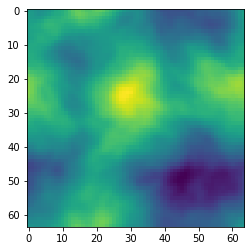

In [15]:
plt.imshow(enhanced_frame[0])